<a href="https://colab.research.google.com/github/Alton01/food_classification_with_pytorch/blob/main/04_food_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cpu'

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if the image folder doesn't exist, download it and prepare it

if image_path.is_dir():
  print(f"{image_path} directory already exists....... skipping download")
else:
  print(f"{image_path} doesn't exists....... creating one")
  image_path.mkdir(parents=True, exist_ok=True)


  # Download Pizza, Steak and Sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading Pizza, Steak and Sushi data")
  f.write(request.content)

  # unzip pizza, steak, sushi data. Extract images and  send to image path
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping Pizza, Steak and Sushi data")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi doesn't exists....... creating one
Unzipping Pizza, Steak and Sushi data


In [5]:
data_path / "pizza_steak_sushi.zip"

PosixPath('data/pizza_steak_sushi.zip')

In [6]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.


In [8]:
# setup test and train paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
# visualizing a random image through code. PIL - Python Imaging Library

import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg")) # directs to a path for the images

# pick random image path

random_image_path = random.choice(image_path_list)


image_class = random_image_path.parent.stem

#open image

img = Image.open(random_image_path)

print(f"Randomimage path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [ ]:
# visualize an image with matplotlib

import numpy as np
import matplotlib.pyplot as plt

#turn the image into an array
img_as_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape}")
plt.axis(False)

In [ ]:
img_as_array

In [12]:
# transforming images/data into pytorch tensors

import torch
from torch.utils.data import DataLoader

from torchvision import datasets, transforms


In [13]:
# transforms are used to help get images ready to be used with a model/perform data augmentation

data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)), # changes image shape and pixel size
    transforms.RandomHorizontalFlip(p=0.5), #probability
    transforms.ToTensor()
])

In [14]:
data_transform(img).dtype

torch.float32

In [ ]:
# comparing original images to transformed images.
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      # transform and plot image
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

In [16]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # transform for data
                                  target_transform=None) # transform for the target / label

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [17]:
class_names = train_data.classes

class_names

['pizza', 'steak', 'sushi']

In [18]:
# Get class names as dict

class_dict = train_data.class_to_idx

class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
len(train_data), len(test_data)

(225, 75)

In [20]:
img, label = train_data[0][0], train_data[0][1]

print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

In [ ]:
img_permute = img.permute(1, 2, 0)

print(f"Original shape: {img.shape}") # (C, H, W)
print(f"Image permuted shape: {img_permute.shape}") # (H, W, C)

plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

In [22]:
# turn test and train data into DataLoader's batches

from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1, # how many cpu cores used to load our data
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d771cc5b250>,
 <torch.utils.data.dataloader.DataLoader at 0x7d771cc2fb50>)

In [23]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


In [24]:
# Loading image data with a custom dataset

import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [25]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [26]:
# creating a helper function to get class names from a directory.

#set up path for target directory

target_directory = train_dir
print(f"Target dir: {target_directory}")

# get class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [27]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  # finds the class folder name in a target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # Raise error if class names could not be found

  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in directory: {directory}.... Please check file structure")

  # create a dictionary of index labels ( computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [28]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [29]:
# create a custom dataset to replicate image folder

# write a custom dataset class

from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self,
               targ_dir: str,
               transform=None):

    # create class attributes
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)


  # create a  function to load images
  def load_image(self, index: int) -> Image.Image:
    # opens an image via a path and returns it.
    image_path = self.paths[index]

    return Image.open(image_path)


  #overwrite __len__
  def __len__(self) -> int:
    # returns total number of samples
    return len(self.paths)


  # overwrite __getitem()__ method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    # loads and returns a sample
    img = self.load_image(index)
    class_name = self.paths[index].parent.name #expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # transformation if necessary (data augmentation)
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label

In [30]:
# create a transform
from torchvision import transforms

train_transforms = transforms.Compose({
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
})

test_transforms = transforms.Compose({
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
})

In [31]:
# test out ImageFolderCustom

train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                        transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)

In [32]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7d771cc76d50>,
 <__main__.ImageFolderCustom at 0x7d771cc90510>)

In [33]:
len(train_data), len(train_data_custom)

(225, 225)

In [34]:
len(test_data), len(test_data_custom)

(75, 75)

In [35]:
# write a helper function to display random images from our custom datasets

# create a function to take in a dataset

def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

  # adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f" For display purposes, n shouldn't be larger than 10")

  # set seed
  if seed:
    random.seed(seed)

  # get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # setup plot
  plt.figure(figsize=(16,8))

  # loop through the random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]


    # adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0)

    # plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"class: {classes[targ_label]}"

      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"

      plt.title(title)

In [ ]:
# display random images from the imagefolder created datasets

display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

In [ ]:
# display random images from the ImageFolderCustom Dataset

display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)

In [38]:
# turn custom loaded images/datasets into  dataloader's

from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom =  DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)

train_dataloader_custom, test_dataloader_custom



(<torch.utils.data.dataloader.DataLoader at 0x7d771c8cf550>,
 <torch.utils.data.dataloader.DataLoader at 0x7d771ca748d0>)

In [39]:
# Get image and label from custom data loader

img_custom, label_custom = next(iter(train_dataloader_custom))

print(f"Image shape: {img_custom.shape}")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 3, 64, 64])
Label shape: torch.Size([32])


In [40]:
# Data augmentation is the process of artificially adding diversity to your training data.
# in the case of image data, this may mean applying various image transformations to the training images.
# image data augmentation is looking at the same image from different perspectives. To artificially increase the diversity of a dataset.

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [41]:
# Get all image paths

image_path_list = list(image_path.glob("*/*/*.jpg"))

image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/416067.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/540882.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/971934.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2124579.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/714866.jpg')]

In [ ]:
#Plot random transformed images

plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=3,
                        seed=None)

In [43]:
# Model 0: TinyVGG Architecture without data augmentation

# create transforms

simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [44]:
# load and transform data

from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform,
                                        )

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# Turn the datasets into DataLoaders

import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create Dataloaders

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [45]:
# Create TinyVGG Model Class.

In [46]:
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
      super().__init__()
      self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                       stride=2)
      )
      self.conv_block_2 = nn.Sequential(
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                       stride=2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
           # we need to ensure hidden values unit on exiting out channels in  nn.Conv2d matches in_features (hidden_unit) hence the 13 * 13
          nn.Linear(in_features=hidden_units*13*13,
                    out_features=output_shape)
      )

  def forward(self, x):
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) benefits from operator fusion
    #this enables you avoid transportation between memory and compute
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    # we need to ensure hidden values unit on exiting out channels in  nn.Conv2d matches in_features (hidden_unit) hence the 13 * 13
    x = self.classifier(x)
    # print(x.shape)
    return x


In [47]:
# create model instance

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)


model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [48]:
# Pass dummy data through model
# Get a single image batch

image_batch, label_batch = next(iter(train_dataloader_simple))

print(f"Image batch shape: {image_batch.shape}")
print(f"Label batch shape: {label_batch.shape}")

Image batch shape: torch.Size([32, 3, 64, 64])
Label batch shape: torch.Size([32])


In [49]:
# Try a forward pass
 # we need to ensure hidden values unit on exiting out channels in  nn.Conv2d matches in_features (hidden_unit) hence the * 13 * 13
model_0(image_batch)

# torch.Size([32, 10, 32, 32])
# torch.Size([32, 10, 13, 13])
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1690 and 10x3)

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

In [50]:
# Using the torchinfo package to get a summary of our model
# Torchinfo can be used to get an idea of the shapes going through our model

In [51]:
#Install torchinfo

try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [52]:
# Train step


def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):

  model.train()

  train_loss, train_acc = 0,0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [53]:
# Test step

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc

In [58]:
# Train and Test Function

from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [ ]:
# train and evaluate model 0

torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()

print(f"Total training time: {end_time-start_time:.3f} seconds")

In [61]:
# plot loss curves: Tracking models progress over time with regards to over-fitting or under-fitting

model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [62]:
def plot_loss_curves(results: Dict[str, List[float]]):
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  #setup a plot

  plt.figure(figsize=(15, 7))

  # Plot the loss

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #plot the accuracy

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

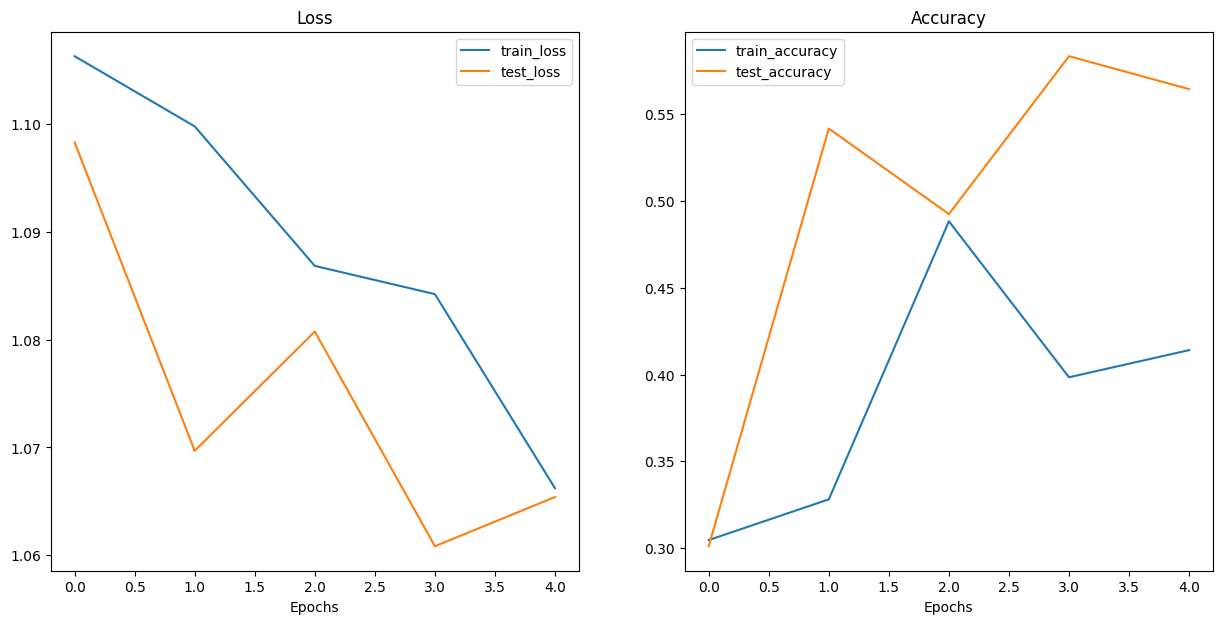

In [64]:
plot_loss_curves(model_0_results)

In [65]:
# Model 1: TinyVGG With Data Augmentation
# Create training transform with TrivialAugment

from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])


In [66]:
# Create train and test datasets and dataloaders with data augmentation
# Turn image folder into datasets

from torchvision import datasets

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                       transform=test_transform_simple)

In [67]:
# turn datasets into dataloaders

import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS,
                                         shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

In [68]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()

print(f"Total training time for model 1: {end_time-start_time:.3f} seconds")

In [ ]:
plot_loss_curves(model_1_results)

In [73]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098321,0.301136
1,1.099806,0.328125,1.069690,0.541667
2,1.086854,0.488281,1.080757,0.492424
3,1.084233,0.398438,1.060832,0.583333
4,1.066216,0.414062,1.065396,0.564394


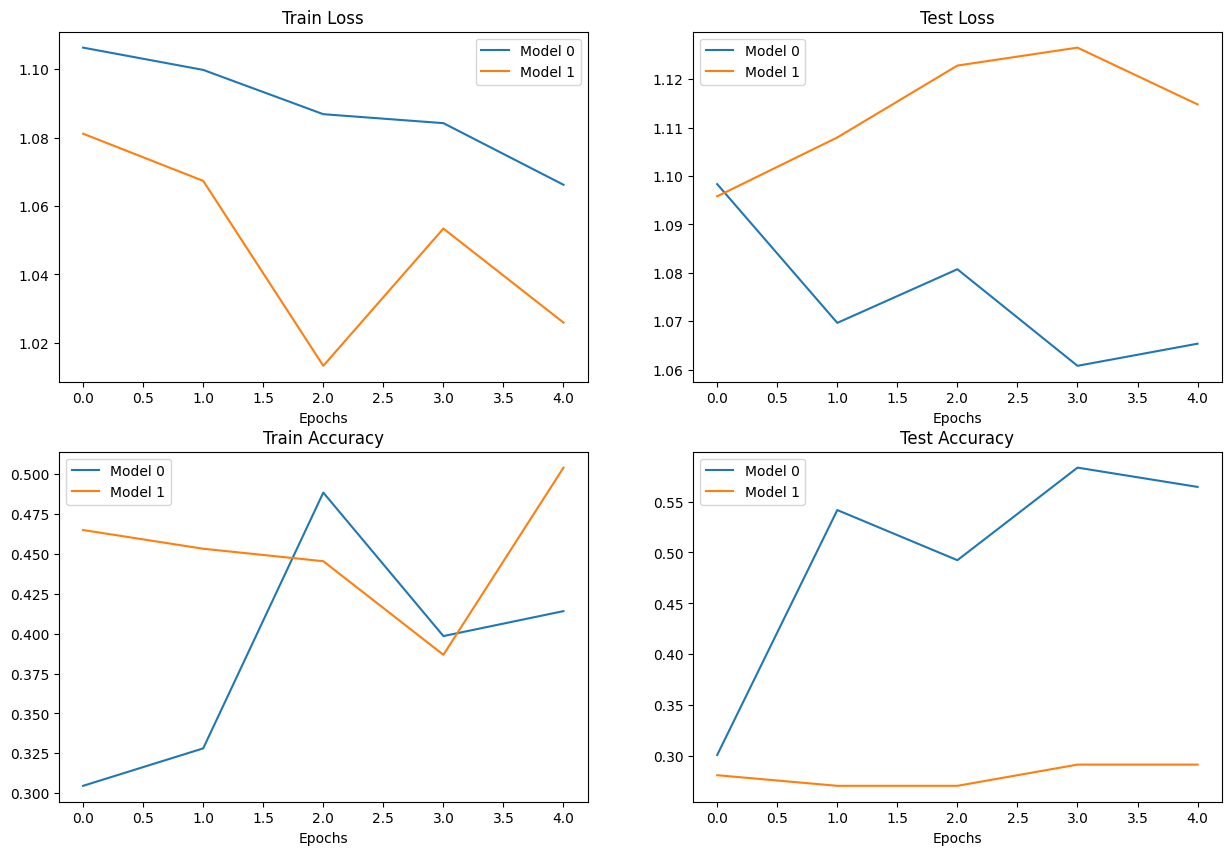

In [76]:
# plot model_0 results against model_1 results

plt.figure(figsize=(15, 10))

epochs = range(len(model_0_df))

#Plot Train Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()


#Plot Test Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()


#Plot Train Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()


#Plot Test Accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

In [77]:
# TOOLS FOR COMPARING MODEL RESULTS

# PyTorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
# Weights & Biases - https://wandb.ai/site/experiment-tracking
# MLFlow - https://mlflow.org

In [80]:
# Making prediction on a custom image by downloading custom image

import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")

    f.write(request.content)

else:
  print(f"{custom_image_path} already exists, skipping download....")

In [89]:
# Loading in custom image with pytorch
# We have to make sure our custom image is in same format as data our model was trained on
# in tensor form with datatype (torch.float32)
# of same shape(64 * 64 * 3)
# On the right device